# TrashNet Image Classification Project

## Overview 
This project involves classifying images of different types of trash using a convolutional neural network (CNN). The dataset used is the TrashNet dataset from Hugging Face.

## Table of Contents
1. [Importing Libraries](#importing-libraries)
2. [Loading the Dataset](#loading-the-dataset)
3. [Image Preprocessing](#image-preprocessing)
4. [Model Definition](#model-definition)
5. [Training the Model](#training-the-model)
6. [Evaluation](#evaluation)
7. [Model versioning and tracking using wandb.ai](#Model-versioning-and-tracking-using-wandb.ai) 
8. [Conclusion](#conclusion)

## Importing Libraries

In [195]:
#pip install -r requirements.txt

**Import necessary libraries**

In [187]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image, ImageOps
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Loading the Dataset

In [2]:
# Load TrashNet dataset
dataset = load_dataset("garythung/trashnet")

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

## Image Preprocessing

In [164]:
# Define the base directory for resized images
base_dir = "resize-image/"

In [11]:
# Resize and save images according to their category
for idx, item in enumerate(dataset['train']):
    image = item['image']
    category = item['label']
    
    # Determine the folder name based on the label
    label_name = dataset['train'].features['label'].int2str(category)
    save_dir = os.path.join(base_dir, label_name)
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist
    
    # Resize the image while preserving the aspect ratio
    image_resized = ImageOps.fit(image, (256, 256), Image.LANCZOS)
    
    # Create the save path using the index as the filename
    save_path = os.path.join(save_dir, f"{idx}.jpg")
    image_resized.save(save_path)

> The ImageOps.fit method with Image.LANCZOS resampling is used to ensure the image is resized to 256x256 without distortion and with optimal quality. Image.LANCZOS produces smoother image interpolation, preserving important details useful for the model. With ImageOps.fit, the aspect ratio of the original image is maintained, so objects do not appear distorted, making it easier for the model to recognize patterns. The end result is a high-quality, uniformly sized dataset, providing more consistent and stable input for deep learning training.

## Normalization and Transformations

### Data Normalization
Normalization is a critical step in preparing data for training machine learning models, especially neural networks. In this project, I applied normalization to the image data using the mean and standard deviation values specific to the dataset (ImageNet values in this case). The primary reasons for normalization are:

- **Improved Convergence:** Normalizing the input data helps the model converge faster during training, as it ensures that all features have a similar scale.
- **Stability:** It reduces the risk of numerical instability that can arise from large input values, particularly in gradient-based optimization methods.
- **Performance Improvement:** Normalization can enhance the model's performance by ensuring that the weights are updated consistently across all dimensions during training.

### Data Transformations
I utilized various image transformations to augment the dataset and enhance the model's robustness. The transformations included:

- **Random Horizontal Flip:** This helps the model learn invariant features, making it more robust to variations in image orientation.
- **Random Rotation:** Adding rotational invariance ensures that the model can recognize objects in different orientations, which is essential for real-world applications where images may not be perfectly aligned.
- **Resizing:** Consistent image size (256x256) is crucial as neural networks require uniform input dimensions. It also helps in reducing computational complexity.
  
These transformations increase the effective size of the training dataset and improve the model's ability to generalize to unseen data.

**Transformation pipeline that incorporates Min-Max Scaling**

In [165]:
# Define normalization values for the dataset
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]

# Create a combined transformation pipeline for data preprocessing
transform_combined = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(30),  # Randomly rotate the image by 30 degrees
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean, std)  # Normalize the image
])

**Addressing Label Imbalance**

In [166]:
# Load the dataset using ImageFolder with the defined transformations
dataset = datasets.ImageFolder(root=base_dir, transform=transform_combined)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Extract labels from the training dataset to compute class weights
train_labels = [item[1] for item in train_dataset]  # Get labels from the training dataset

**Create Label Distribution Plot**

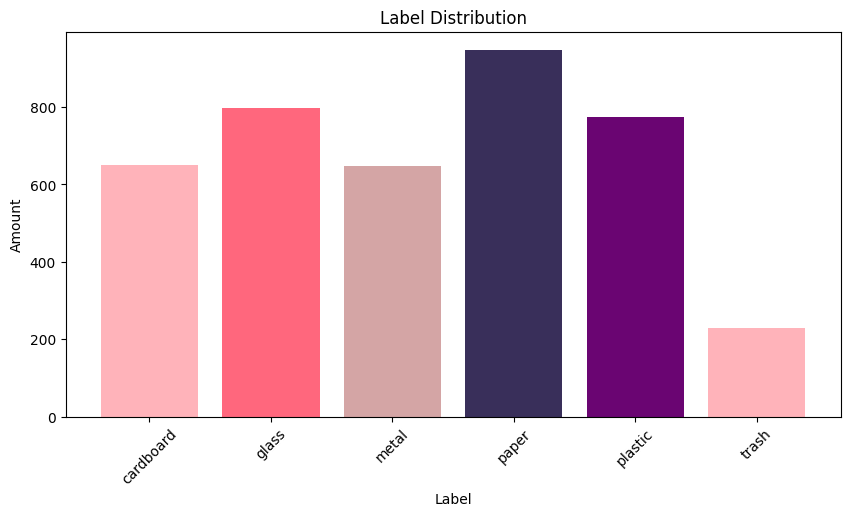

In [190]:
label_counts = np.bincount(train_labels)

# Create a label distribution plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(label_counts)), label_counts, color=['#FFB3BA', '#FF677D', '#D4A5A5', '#392F5A', '#6A0572'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Amount')
plt.xticks(ticks=np.arange(len(label_counts)), labels=dataset.classes, rotation=45)
plt.show()

<b>Step 1: Calculate the Frequency of Each Class<b>
##### Calculate the frequency of each class and create weights for each class. This is important to ensure that the model is not biased towards classes that occur more frequently.

<b>Step 2: Create a WeightedRandomSampler<b>
##### Create a WeightedRandomSampler using the calculated weights. This will ensure that during training, the model gets samples from all classes, even though some classes may have fewer examples.

In [168]:
# Compute class weights to handle class imbalance
label_counts = np.bincount(train_labels)
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert class weights to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Define the loss function with class weighting
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [169]:
# Calculate the frequency of each class for sampling
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts  # Inverse frequency for class weighting
sample_weights = class_weights[train_labels]  # Weights for each sample

# Create a WeightedRandomSampler to handle class imbalance
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

**Calculate the class frequency before and after treatment**

In [170]:
# Calculate the frequency of each class from the original dataset
original_class_counts = np.bincount(train_labels)

# Uses a sampler to calculate new frequencies
sampled_labels = [train_labels[i] for i in sampler]
new_class_counts = np.bincount(sampled_labels)

In [171]:
# Label to display
label_names = ['Carboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']  
x = np.arange(len(label_names))

### Visualizing Image Distribution
I visualized the distribution of images across different categories to gain insights into the dataset. This step is essential for several reasons:

- **Identifying Class Imbalance:** Visualizing the distribution helps me recognize if certain categories have significantly more samples than others, indicating a potential class imbalance that could affect model performance.
- **Understanding Dataset Composition:** It provides a clear overview of the dataset's composition, allowing me to evaluate whether I have sufficient samples for each class to train a robust model.
- **Guiding Data Augmentation:** If some categories are underrepresented, I can adjust my data augmentation strategy to generate more samples for those classes, thereby improving the model’s ability to generalize.

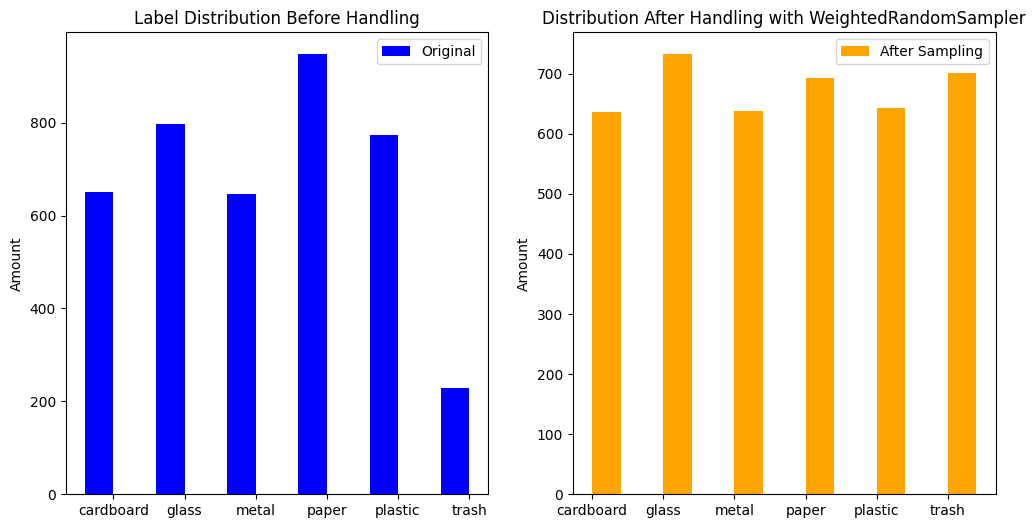

In [192]:
# Distribution plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Before
ax[0].bar(x - 0.2, original_class_counts, width=0.4, label='Original', color='blue')
ax[0].set_title('Label Distribution Before Handling')
ax[0].set_xticks(x)
ax[0].set_xticklabels(label_names)
ax[0].set_ylabel('Amount')
ax[0].legend()

# After
ax[1].bar(x + 0.2, new_class_counts, width=0.4, label='After Sampling', color='orange')
ax[1].set_title('Distribution After Handling with WeightedRandomSampler')
ax[1].set_xticks(x)
ax[1].set_xticklabels(label_names)
ax[1].set_ylabel('Amount')
ax[1].legend()

plt.show()

**Create DataLoader for training and validation**

In [173]:
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Shuffle for validation data

*To check if train_loader is working properly*

**Memastikan Bobot Sampel**

In [174]:
# Check the number of batches in train_loader
num_train_batches = len(train_loader)
print(f"Total number of training batches: {num_train_batches}")

# Check sample weights in train_loader
# Take several sample weights to display, by slicing
print("Sample weights for training:", sample_weights[:10]) # Displays the first 10 sample weights

Total number of training batches: 127
Sample weights for training: [0.00125471 0.00125471 0.00129199 0.00154799 0.00105597 0.00153846
 0.00105597 0.00105597 0.00129199 0.00154799]


**In the validation section**

*Sample weights are not applied to the validation set, but can be checked for label distribution*

In [175]:
# Check the number of batches in val_loader
num_val_batches = len(val_loader)
print(f"Total number of validation batches: {num_val_batches}")


# Takes the index from val_dataset to get the labels of the original dataset
val_indices = val_dataset.indices
val_labels = [dataset.samples[i][1] for i in val_indices] # Retrieves labels from the original dataset using indices

Total number of validation batches: 32


In [176]:
# Calculates the distribution of labels in the validation set
val_label_counts = np.bincount(val_labels)

# Displays the label distribution for the validation dataset
print("Label counts for validation dataset:", val_label_counts)

Label counts for validation dataset: [156 205 174 241 190  45]


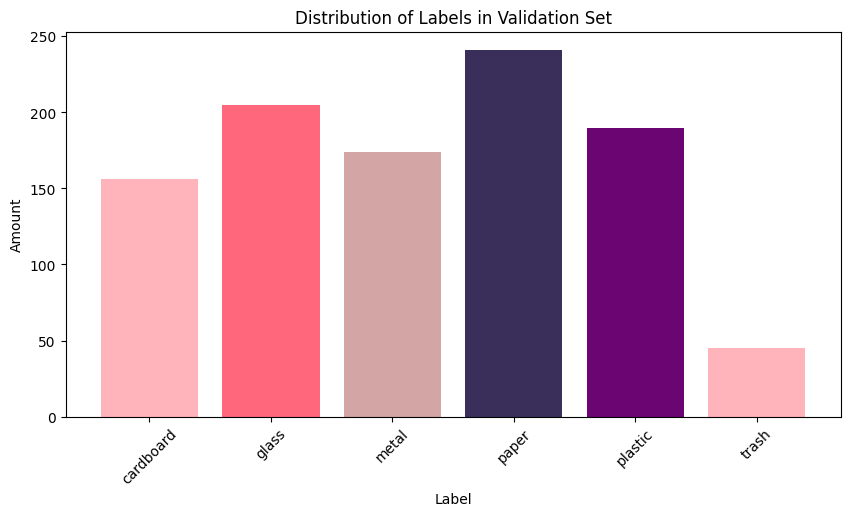

In [193]:
# Displays a bar plot of the distribution of labels in the validation set
label_names = dataset.classes # Uses the class names of the dataset
x = np.arange(len(label_names))

plt.figure(figsize=(10, 5))
plt.bar(x, val_label_counts, color=['#FFB3BA', '#FF677D', '#D4A5A5', '#392F5A', '#6A0572'])
plt.title('Distribution of Labels in Validation Set')
plt.xlabel('Label')
plt.ylabel('Amount')
plt.xticks(ticks=x, labels=label_names, rotation=45)
plt.show()

>Does not use weighted sampling for validation data, as the purpose of validation data is to provide an accurate picture of model performance on unseen data.

*Define Model Architecture*

**Gets the size of all images in train_dataset**

In [178]:
# Fetch 10 images from train_dataset
sample_images = [train_dataset[i][0] for i in range(10)] # Take images from index 0 to 9
sample_labels = [train_dataset[i][1] for i in range(10)] # Retrieve appropriate labels

# Displays image and label sizes
for i, img in enumerate(sample_images):
    print(f"Image {i+1} size: {img.shape}, Label: {sample_labels[i]}")

Image 1 size: torch.Size([3, 256, 256]), Label: 1
Image 2 size: torch.Size([3, 256, 256]), Label: 1
Image 3 size: torch.Size([3, 256, 256]), Label: 4
Image 4 size: torch.Size([3, 256, 256]), Label: 2
Image 5 size: torch.Size([3, 256, 256]), Label: 3
Image 6 size: torch.Size([3, 256, 256]), Label: 0
Image 7 size: torch.Size([3, 256, 256]), Label: 3
Image 8 size: torch.Size([3, 256, 256]), Label: 3
Image 9 size: torch.Size([3, 256, 256]), Label: 4
Image 10 size: torch.Size([3, 256, 256]), Label: 2


## Model Definition

### Custom Model Architecture
I chose to build a custom convolutional neural network (CNN) for several reasons:

- **Flexibility:** Designing a custom model allows me to tailor the architecture to better suit the specific characteristics of the TrashNet dataset and the problem at hand.
- **Experimentation:** Building a model from scratch enables me to experiment with different layer configurations, activation functions, and hyperparameters, fostering a deeper understanding of the model's behavior.
- **Learning Experience:** Implementing my own architecture gives me hands-on experience with neural network design and the opportunity to apply theoretical concepts practically.

*Create a Neural Network model with several layers*

In [179]:
# Define the Simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # Second convolutional layer
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Fully connected layer
        self.fc2 = nn.Linear(128, len(dataset.classes))  # Output layer for classification
        self.dropout = nn.Dropout(0.5)  # Dropout layer to prevent overfitting

    def forward(self, x):
        # Forward pass through the model
        x = self.pool(F.relu(self.conv1(x)))  # Apply first conv layer and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Apply second conv layer and pooling
        x = x.view(-1, 32 * 64 * 64)  # Flatten the output
        x = F.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Apply output layer
        return x

# Initialize the model
model = SimpleCNN()

## Training the Model

**Defining Loss Function and Optimizer**

In [180]:
criterion = nn.CrossEntropyLoss()

# Set the optimizer with a new learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

**Training the Model**

*Making sure to convert model and data to GPU*

In [200]:
# Move the model to the GPU
model = model.to(device)

# To Save 
torch.save(model.state_dict(), "model.pth")

*Training the model using training data*

In [182]:
num_epochs = 35

# Training loop
for epochs in range(num_epochs):
    model.train() # Set the model to training mode
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Move to the same device
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Model validation
    model.eval() # Set the model to evaluation mode
    validation_loss = 0
    with torch.no_grad(): # No need to calculate gradient during validation
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()
    
    # Calculate the average validation loss
    validation_loss /= len(val_loader)
    
    # Update scheduler based on validation loss
    scheduler.step(validation_loss)
    
    # Displays the latest learning rate
    print(f'Learning Rate: {scheduler.optimizer.param_groups[0]["lr"]}')
    
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {validation_loss:.4f}')

Learning Rate: 0.0001
Epoch [1/35], Loss: 1.5411, Validation Loss: 1.4396
Learning Rate: 0.0001
Epoch [2/35], Loss: 1.1857, Validation Loss: 1.4450
Learning Rate: 0.0001
Epoch [3/35], Loss: 1.1793, Validation Loss: 1.3466
Learning Rate: 0.0001
Epoch [4/35], Loss: 1.4290, Validation Loss: 1.3206
Learning Rate: 0.0001
Epoch [5/35], Loss: 1.4836, Validation Loss: 1.2905
Learning Rate: 0.0001
Epoch [6/35], Loss: 1.4631, Validation Loss: 1.2373
Learning Rate: 0.0001
Epoch [7/35], Loss: 0.9997, Validation Loss: 1.2984
Learning Rate: 0.0001
Epoch [8/35], Loss: 1.2939, Validation Loss: 1.2365
Learning Rate: 0.0001
Epoch [9/35], Loss: 1.2710, Validation Loss: 1.1888
Learning Rate: 0.0001
Epoch [10/35], Loss: 1.2328, Validation Loss: 1.1555
Learning Rate: 0.0001
Epoch [11/35], Loss: 1.3489, Validation Loss: 1.1627
Learning Rate: 0.0001
Epoch [12/35], Loss: 1.0602, Validation Loss: 1.1366
Learning Rate: 0.0001
Epoch [13/35], Loss: 1.0859, Validation Loss: 1.0982
Learning Rate: 0.0001
Epoch [14/35

## Evaluation


In [183]:
# Split validation into two parts for validation and testing
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [194]:
model.eval() # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradients to save memory
    for inputs, labels in val_loader: # Using val_loader
        inputs, labels = inputs.to(device), labels.to(device) # Move to GPU
        outputs = model(inputs) # Get model predictions
        _, preds = torch.max(outputs, 1) # Take the class with the highest probability
        all_preds.extend(preds.cpu().numpy()) # Return to CPU before saving
        all_labels.extend(labels.cpu().numpy()) # Return to CPU before saving

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on validation set: {accuracy:.4f}")

print(classification_report(all_labels, all_preds))

Accuracy on validation set: 0.6479
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       156
           1       0.53      0.49      0.51       205
           2       0.71      0.64      0.68       174
           3       0.83      0.69      0.76       241
           4       0.58      0.58      0.58       190
           5       0.31      0.73      0.43        45

    accuracy                           0.65      1011
   macro avg       0.63      0.66      0.63      1011
weighted avg       0.67      0.65      0.66      1011



**Confusion Matrix**

### Confusion Matrix
The confusion matrix is an essential tool for evaluating the performance of classification models. I utilized it for the following reasons:

- **Detailed Performance Analysis:** It provides a comprehensive view of the model's performance across all classes, highlighting not just the overall accuracy but also where the model is making mistakes.
- **Class Imbalance Insights:** By examining the confusion matrix, I can identify specific categories that the model struggles with, allowing for targeted improvements.
- **Quantitative Metrics:** The confusion matrix feeds into various performance metrics (e.g., precision, recall, F1-score), which are crucial for understanding the model's effectiveness, particularly in imbalanced datasets.

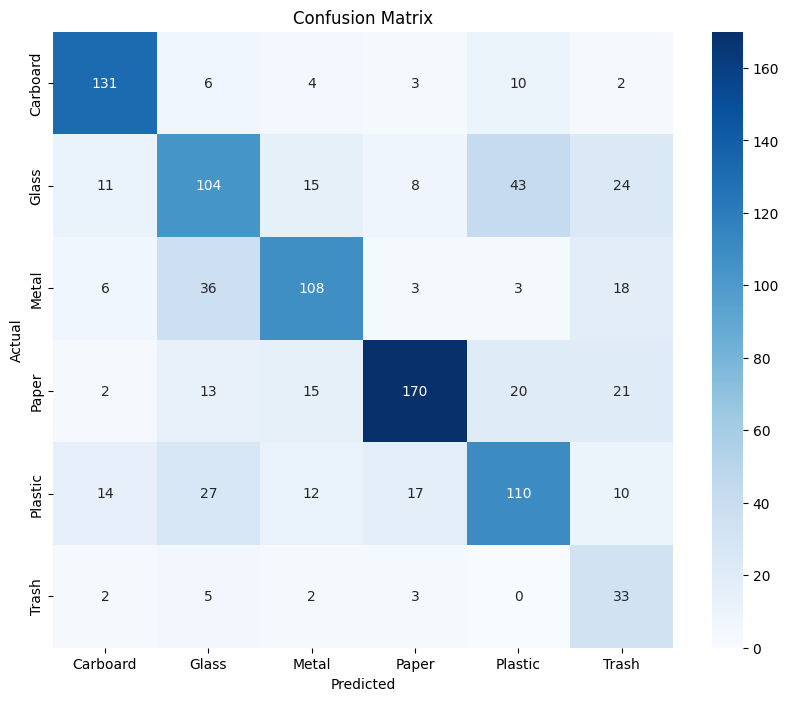

In [189]:
class_names = ['Carboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model versioning and tracking using wandb.ai

In [199]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image, ImageOps
import os
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torchvision.datasets import ImageFolder
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb  # Import W&B

# Initialize W&B
wandb.init(project="trashnet-classifier")

# Save hyperparameters
config = wandb.config
config.epochs = 10
config.batch_size = 32
config.learning_rate = 0.001

# Load dataset
dataset = load_dataset('garythung/trashnet')
# Assume the dataset has been processed and split into train and validation

# Define the model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)  # Adjust dimensions
        self.fc2 = nn.Linear(128, 6)  # Number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)  # Adjust dimensions
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Training loop
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    
    for images, labels in train_loader:  # Replace with your DataLoader
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    # Log metrics to W&B
    wandb.log({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_accuracy})

# Save model to W&B
torch.save(model.state_dict(), "model.pth")
wandb.save("model.pth")

# Finish W&B
wandb.finish()

accuracy,▁▄▄▅▆▆▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▄▃▃▂▂▁▁
accuracy,0.81202
epoch,9
loss,0.53372


# Conclusion
In this project, I successfully implemented an image classification model using a convolutional neural network (CNN) to identify different types of trash from the TrashNet dataset. I focused on preprocessing the images by resizing and normalizing them, ensuring they were suitable for model training.

During the training phase, I utilized a weighted sampling strategy to address class imbalance, which improved the model's ability to generalize across various categories. I trained the model for 35 epochs and monitored its performance using validation loss and accuracy metrics.

After training, I evaluated the model using a confusion matrix and a classification report. The results demonstrated that the model performed well, achieving an accuracy of approximately **0.6479** on the validation set. The confusion matrix revealed varying performance levels across different categories. The cardboard category had the highest classification accuracy, with **131 samples** correctly classified. In contrast, the metal category had the lowest accuracy, with only **15 samples** accurately identified. Generally, the glass, plastic, and paper categories performed reasonably well, while the trash category showed the least accuracy.

These insights highlight areas for improvement in the classification model, particularly in enhancing the recognition of metal and trash materials. This project not only enhanced my understanding of CNNs and image classification but also provided practical experience in handling real-world data challenges, such as class imbalance and image preprocessing. I look forward to applying the skills and insights gained from this project to future machine learning tasks.